In [1]:
# import kagglehub

# path = kagglehub.dataset_download("hrokrin/the-largest-diamond-dataset-currely-on-kaggle")
# filepath = path + '\\diamonds.csv'
# filepath

# Libraries

In [2]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

from imblearn.ensemble import BalancedRandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# Helper functions

### `info_df`

This is a function that I plan to keep developing with more information columns in the returned dataframe.

In [3]:
def info_df(df, print_result=False):
    non_null = len(df)-df.isnull().sum().values
    null = df.isnull().sum().values
    pct_non_null = np.round(100 * non_null / (non_null + null), 0)
    types = df.dtypes.values
    
    info_df = pd.DataFrame({
            "name": df.columns,
            "non_null": non_null,
            "null": null,
            "non_null_pct": pct_non_null,
            "type": types
        })
    
    if print_result:
        print(info_df)
        print()
        print(f'{df.shape[0]:,} rows')
        
    return info_df

### `plot_corr_heatmap`

In [4]:
def plot_corr_heatmap(df, method):
    '''
    Plots a heatmap of the correlation matrix for df.
    Inputs:
        Dataframe: Dataframe to compute pairwise column correlations
        method: {‘pearson’, ‘kendall’, ‘spearman’} or callable
    '''

    # Copied code from seaborn examples
    # https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    sns.set(style="white")

    # Generate a mask for the upper triangle
    mask = np.zeros_like(df.corr())
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    # sns.heatmap(df.corr(), mask=mask, cmap=cmap, vmax=1, center=0,
    #             square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    sns.heatmap(df.corr(method=method, numeric_only=True), cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

### `print_scores`

In [5]:
def print_scores(training_score, testing_score, metric='R^2'):
    print(f'Training {metric}: {training_score:.4}')
    print(f'Testing {metric}: {testing_score:.4}')

# Load data

## Filepath & categorical variables

### Filepath

In [6]:
filepath = 'C:\\Users\\jlefe\\.cache\\kagglehub\\datasets\\hrokrin\\the-largest-diamond-dataset-currely-on-kaggle\\versions\\1\\diamonds.csv'

1. Read "unknown" as NaN
2. Create & assign customized categorial data types
2. Read `eye_clean` value of 'E1' as NaN, by excluding it from the domain specification
    - The rating is ambiguous
    - This rating only occurs in rows attributed to the GIA lab, whereas the GIA (Gemological Institute of America) professes not to use eye clean as a grading factor.
    - 300 of ~220K rows - only 1.4% of data set
3. Rename `cut` to `shape` (avoid confusion with traditional 'cut' which here is `cut_quality`)

### Define categorical variables

In [7]:
nom_vars = ['cut', 'lab', 'fancy_color_dominant_color', 'fancy_color_secondary_color', 'fancy_color_overtone', 'fancy_color_intensity']
nominal_cat = {col_name:'category' for col_name in nom_vars}

# Quality categories are ordered from worst to best
ordinal_cat = {
    'cut_quality':CategoricalDtype(['Fair', 'Good', 'Very Good', 'Excellent', 'Ideal'], ordered=True),
    'color':CategoricalDtype(['M', 'L', 'K', 'J', 'I', 'H', 'G', 'F', 'E', 'D'], ordered=True),
    'clarity':CategoricalDtype(['I3', 'I2', 'I1', 'SI3', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'], ordered=True),
    'symmetry': CategoricalDtype(['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'], ordered=True),
    'polish': CategoricalDtype(['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'], ordered=True),
    'eye_clean': CategoricalDtype(['No', 'Borderline', 'Yes'], ordered=True),
    'culet_size': CategoricalDtype(['EL', 'VL', 'L', 'SL', 'M', 'S', 'VS', 'N'], ordered=True),
    'culet_condition': CategoricalDtype(['Chipped', 'Abraded', 'Pointed'], ordered=True),
    'girdle_min': CategoricalDtype(['XTN', 'VTN', 'STN', 'TN', 'M', 'STK', 'TK', 'VTK', 'XTK'], ordered=True),
    'girdle_max': CategoricalDtype(['XTN', 'VTN', 'STN', 'TN', 'M', 'STK', 'TK', 'VTK', 'XTK'], ordered=True),
}

ord_vars = list(ordinal_cat.keys())

## (1) Load

In [8]:
diamonds = pd.read_csv(filepath, index_col=0, na_values=['unknown'], dtype={**ordinal_cat, **nominal_cat})
diamonds.rename(columns={'cut':'shape', 'color':'clear_color_quality'}, inplace=True)
# print(info_df(diamonds))

## Update variable lists

They will be used later.

In [9]:
nom_vars.remove('cut')
nom_vars.append('shape')

ord_vars.remove('color')
ord_vars.append('clear_color_quality')

num_vars = list(diamonds.select_dtypes(include = 'number').columns)

print(f'Continuous variables: {num_vars}')
print(f'Ordinal variables: {ord_vars}')
print(f'Nominal variables: {nom_vars}')

Continuous variables: ['carat_weight', 'depth_percent', 'table_percent', 'meas_length', 'meas_width', 'meas_depth', 'total_sales_price']
Ordinal variables: ['cut_quality', 'clarity', 'symmetry', 'polish', 'eye_clean', 'culet_size', 'culet_condition', 'girdle_min', 'girdle_max', 'clear_color_quality']
Nominal variables: ['lab', 'fancy_color_dominant_color', 'fancy_color_secondary_color', 'fancy_color_overtone', 'fancy_color_intensity', 'shape']


# (2) Initial data cleaning
- Remove lab column
- Remove duplicates
- Remove 0s from numeric columns (invalid data)
- Encode ordinal variables

In [10]:
# Remove 'lab' column
diamonds.drop(columns='lab', inplace=True, errors='ignore')

# Remove duplicates
diamonds.drop_duplicates(inplace=True)

# Remove rows with 0 values in numerical data
diamonds = diamonds[~(diamonds[num_vars] <= 0).any(axis=1)]

# Encode ordinal categories
diamonds = pd.DataFrame({
    var_name: diamonds[var_name].cat.codes.where(diamonds[var_name].notna()) if var_name in ord_vars else diamonds[var_name]
    for var_name in diamonds.columns
})

# Separate & recombine

## (3a) Separate

### Fancy diamonds
- Define
- Drop columns with na
- Remove volume measures

### Clear diamonds
- Define
- Drop columns with >50% na
- Remove the rest of the missing data by removing rows with missing values
- Remove volume measures

In [11]:
# fancy diamonds
fancy_diamonds = diamonds[diamonds.fancy_color_dominant_color.notna()].copy()
fancy_diamonds.dropna(axis='columns', inplace=True)

volume_measures = ['meas_length', 'meas_width', 'meas_depth']
fancy_diamonds.drop(columns=volume_measures, inplace=True, errors='ignore')

# clear diamonds
clear_diamonds = diamonds[diamonds.fancy_color_dominant_color.isna()].drop(columns=[col_name for col_name in diamonds.columns if col_name.startswith('fancy')])

clear_info = info_df(clear_diamonds)
drop_cols = list(clear_info[clear_info.non_null_pct < 50]['name'])
clear_diamonds.drop(columns=drop_cols, inplace=True, errors='ignore')

clear_diamonds.dropna(inplace=True)
clear_diamonds.drop(columns=volume_measures, inplace=True, errors='ignore')

## (3b) Combine

In [12]:
# dominant_color:
#   Rename `fancy_color_dominant_color` to `dominant_color` in `fancy_diamonds`.
#   Add `dominant_color` to `clear_diamonds` with value 'clear'
fancy_diamonds.rename(columns={'fancy_color_dominant_color':'dominant_color'}, inplace=True)
clear_diamonds['dominant_color'] = 'clear'

# Which columns are useful for both sets?
clear_columns = set(clear_diamonds.columns)
fancy_columns = set(fancy_diamonds.columns)
common_columns = list(clear_columns.intersection(fancy_columns))

# Redefine diamonds
diamonds = pd.concat([fancy_diamonds[common_columns], clear_diamonds[common_columns]])
diamonds['dominant_color'] = diamonds['dominant_color'].astype('category') #Recast after adding new value "clear"

diamonds['is_fancy'] = diamonds.dominant_color != 'clear'

# (4) Get dummy variables for `shape` and `dominant_color`

Saved until last b/c this creates so many extra columns

In [13]:
shape_dummies = pd.get_dummies(diamonds['shape'], dtype='int', prefix='shape')
color_dummies = pd.get_dummies(diamonds['dominant_color'], dtype='int', prefix='color')

diamonds = diamonds.drop(columns='shape').merge(shape_dummies, left_index=True, right_index=True)
diamonds = diamonds.drop(columns='dominant_color').merge(color_dummies, left_index=True, right_index=True)
diamonds.columns = diamonds.columns.str.replace(' ', '_')

In [14]:
for c in color_dummies.columns:
    print(c)

color_Black
color_Blue
color_Brown
color_Chameleon
color_Gray
color_Green
color_Orange
color_Other
color_Pink
color_Purple
color_Red
color_Yellow
color_clear


These are some short helper functions that will make later code easier & more readable

In [15]:
def drop_colors(df):
    return df.drop(columns=[c for c in df.columns if c.startswith('color_')])

def drop_shapes(df):
    return df.drop(columns=[c for c in df.columns if c.startswith('shape_')])

⛔ Do not modify `diamonds` going forward. Only make copies.

# Keep track of scores for different classificatoin models

In [16]:
classification_accuracy_scores = []

# 💎 Balanced random forest, revisited

Use a balanced model because the proportion of fancy diamonds is quite small (~10%)

Notes on the parameters, from the documentation:
- The default of `bootstrap` will change from `True` to `False` in version 0.13.
- Bootstrapping is already taken care by the internal sampler using `replacement=True`.

## Create separate dataframes with and without the 'shape' column

Fancy diamonds have a greater variety of shapes (11) than clear diamonds (9). Could this be influencing the almost-too-good results?

Create separate dataframes to run an addition RF without the shape columns.

In [17]:
no_color = drop_colors(diamonds)
no_color_no_shape = drop_shapes(no_color)

Get fancy proportion:

In [18]:
fancy_pct = no_color.is_fancy.value_counts()[True] / no_color.is_fancy.value_counts()[False]

print(no_color.is_fancy.value_counts())
print(f'Fancy percent:{fancy_pct:.2%}')

is_fancy
False    85065
True      8923
Name: count, dtype: int64
Fancy percent:10.49%


## With shape

### Setup: Features & target; training and test sets

In [19]:
X_with_shape = no_color.drop(columns='is_fancy')
y_with_shape = no_color['is_fancy']
X_with_shape_train, X_with_shape_test, y_with_shape_train, y_with_shape_test = train_test_split(X_with_shape, y_with_shape, random_state=42, shuffle=True)

###  Model

In [20]:
with_shape_rfc = BalancedRandomForestClassifier(sampling_strategy='all', replacement=True, bootstrap=False)
with_shape_rfc.fit(X_with_shape_train, y_with_shape_train)
y_with_shape_train_pred = with_shape_rfc.predict(X_with_shape_train)
y_with_shape_test_pred = with_shape_rfc.predict(X_with_shape_test)

### Results

#### Training results

In [21]:
training_acc = accuracy_score(y_with_shape_train, y_with_shape_train_pred)

print(confusion_matrix(y_with_shape_train, y_with_shape_train_pred))
print()
print(f'Accuracy: {training_acc:.2%}')
print()
print(classification_report(y_with_shape_train, y_with_shape_train_pred))

[[63593   159]
 [    0  6739]]

Accuracy: 99.77%

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     63752
        True       0.98      1.00      0.99      6739

    accuracy                           1.00     70491
   macro avg       0.99      1.00      0.99     70491
weighted avg       1.00      1.00      1.00     70491



#### Testing results

In [22]:
testing_acc = accuracy_score(y_with_shape_test, y_with_shape_test_pred)

print(confusion_matrix(y_with_shape_test, y_with_shape_test_pred))
print()
print(f'Accuracy: {accuracy_score(y_with_shape_test, y_with_shape_test_pred):.2%}')
print()
print(classification_report(y_with_shape_test, y_with_shape_test_pred))

[[21262    51]
 [   15  2169]]

Accuracy: 99.72%

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     21313
        True       0.98      0.99      0.99      2184

    accuracy                           1.00     23497
   macro avg       0.99      1.00      0.99     23497
weighted avg       1.00      1.00      1.00     23497



##### Log score

In [23]:
classification_accuracy_scores.append(('BRF', training_acc, testing_acc))

## Without shape

### Setup: Features & target; training and test sets

In [24]:
X_no_shape = no_color_no_shape.drop(columns='is_fancy')
y_no_shape = no_color_no_shape['is_fancy']
X_no_shape_train, X_no_shape_test, y_no_shape_train, y_no_shape_test = train_test_split(X_no_shape, y_no_shape, random_state=42, shuffle=True)

###  Model

In [25]:
no_shape_rfc = BalancedRandomForestClassifier(sampling_strategy='all', replacement=True, bootstrap=False)
no_shape_rfc.fit(X_no_shape_train, y_no_shape_train)
y_no_shape_train_pred = no_shape_rfc.predict(X_no_shape_train)
y_no_shape_test_pred = no_shape_rfc.predict(X_no_shape_test)

### Results

#### Training results

In [26]:
training_acc = accuracy_score(y_no_shape_train, y_no_shape_train_pred)

print(confusion_matrix(y_no_shape_train, y_no_shape_train_pred))
print()
print(f'Accuracy: {training_acc:.2%}')
print()
print(classification_report(y_no_shape_train, y_no_shape_train_pred))


[[63253   499]
 [    0  6739]]

Accuracy: 99.29%

              precision    recall  f1-score   support

       False       1.00      0.99      1.00     63752
        True       0.93      1.00      0.96      6739

    accuracy                           0.99     70491
   macro avg       0.97      1.00      0.98     70491
weighted avg       0.99      0.99      0.99     70491



#### Testing results

In [27]:
testing_acc = accuracy_score(y_no_shape_test, y_no_shape_test_pred)

print(confusion_matrix(y_no_shape_test, y_no_shape_test_pred))
print()
print(f'Accuracy: {testing_acc:.2%}')
print()
print(classification_report(y_no_shape_test, y_no_shape_test_pred))

[[21075   238]
 [   73  2111]]

Accuracy: 98.68%

              precision    recall  f1-score   support

       False       1.00      0.99      0.99     21313
        True       0.90      0.97      0.93      2184

    accuracy                           0.99     23497
   macro avg       0.95      0.98      0.96     23497
weighted avg       0.99      0.99      0.99     23497



##### Log score

In [28]:
classification_accuracy_scores.append(('BRF_no_shape', training_acc, testing_acc))

# 💎 SVC

## Setup: Features & target; scaling; training and test sets

(NB: Using Euclidean distance)

In [29]:
# Features & target
X = drop_colors(diamonds).drop(columns='is_fancy')
y = diamonds.is_fancy

# Scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train/test splits
X_svc_train, X_svc_test, y_svc_train, y_svc_test = train_test_split(X_scaled, y)

## Model

In [30]:
svm = SVC(kernel='linear', probability=True)
svm.fit(X_svc_train, y_svc_train)
y_svc_train_pred = svm.predict(X_svc_train)
y_svc_test_pred = svm.predict(X_svc_test)

### Training results

In [31]:
training_acc = accuracy_score(y_svc_train, y_svc_train_pred)

print(f'Accuracy: {training_acc:.2%}')
print()
print(classification_report(y_svc_train, y_svc_train_pred))

Accuracy: 99.73%

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     63762
        True       0.98      0.99      0.99      6729

    accuracy                           1.00     70491
   macro avg       0.99      0.99      0.99     70491
weighted avg       1.00      1.00      1.00     70491



### Testing results

In [32]:
testing_acc = accuracy_score(y_svc_test, y_svc_test_pred)

print(f'Accuracy: {testing_acc:.2%}')
print()
print(classification_report(y_svc_test, y_svc_test_pred))

Accuracy: 99.72%

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     21303
        True       0.98      0.99      0.98      2194

    accuracy                           1.00     23497
   macro avg       0.99      0.99      0.99     23497
weighted avg       1.00      1.00      1.00     23497



##### Log score

In [33]:
classification_accuracy_scores.append(('SVC', training_acc, testing_acc))

# 💎 KMeans clusters

Without any color information or a training set, can the fancy/clear classes be identified?

## Scale data

(NB: Using Euclidean distance)

In [34]:
no_color_km = drop_colors(diamonds)
scaler = StandardScaler()

# Note 'is_fancy' not included in scaled data
no_color_km_scaled = scaler.fit_transform(no_color_km.drop(columns='is_fancy'))

## KMeans

In [51]:
km = KMeans(n_clusters=2)
km.fit(no_color_km_scaled)
no_color_km['cluster'] = km.labels_

In [52]:
pd.pivot_table(data=no_color_km, values='polish', aggfunc='count', index='is_fancy', columns='cluster').sort_index()

cluster,0,1
is_fancy,,
False,297,84768
True,8836,87


Map cluster numbers to (Boolean) outcomes.  Pay attention: 0 does not aways map to False. 

In [53]:
associations = no_color_km.groupby(['cluster', 'is_fancy']).count().iloc[:, 0]
max_association = associations[associations == associations.max()].reset_index()
max_cluster = max_association['cluster'][0]
max_is_fancy = max_association['is_fancy'][0]
cluster_map = {}
cluster_map[max_cluster] = max_is_fancy
other_cluster = 0 if max_cluster == 1 else 1
cluster_map[other_cluster] = not cluster_map[max_cluster]
cluster_map

{1: False, 0: True}

In [58]:
no_color_km['cluster_is_fancy'] = no_color_km['cluster'].map(cluster_map)

acc = accuracy_score(no_color_km.is_fancy, no_color_km.cluster_is_fancy)

print(confusion_matrix(no_color_km.is_fancy, no_color_km.cluster_is_fancy))
print()
print(f'Accuracy: {acc:.2%}')
print(classification_report(no_color_km.is_fancy, no_color_km.cluster_is_fancy))


[[84768   297]
 [   87  8836]]

Accuracy: 99.59%
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     85065
        True       0.97      0.99      0.98      8923

    accuracy                           1.00     93988
   macro avg       0.98      0.99      0.99     93988
weighted avg       1.00      1.00      1.00     93988



😊 Not bad

##### Log score

In [61]:
acc

0.9959143720474954

In [64]:
classification_accuracy_scores.append(('KMeans', 0, acc))


In [65]:
classification_accuracy_scores

[('BRF', 0.9977443929012214, 0.9971911307826531),
 ('BRF_no_shape', 0.9929210821239591, 0.9867642677788654),
 ('SVC', 0.9972620618234952, 0.9971911307826531),
 ('KMeans', 0, 0.9959143720474954)]

# Classification accuracy scores

In [60]:
# del(classification_accuracy_scores[-2])
classification_accuracy_scores

[('BRF', 0.9977443929012214, 0.9971911307826531),
 ('BRF_no_shape', 0.9929210821239591, 0.9867642677788654),
 ('SVC', 0.9972620618234952, 0.9971911307826531),
 ('KMeans', 0, 0.9215325360684342)]

In [66]:
class_acc = pd.DataFrame.from_records(classification_accuracy_scores, columns=['model', 'training_accuracy', 'testing_accuracy'])
class_acc

,model,training_accuracy,testing_accuracy
0,BRF,0.997744,0.997191
1,BRF_no_shape,0.992921,0.986764
2,SVC,0.997262,0.997191
3,KMeans,0.000000,0.995914


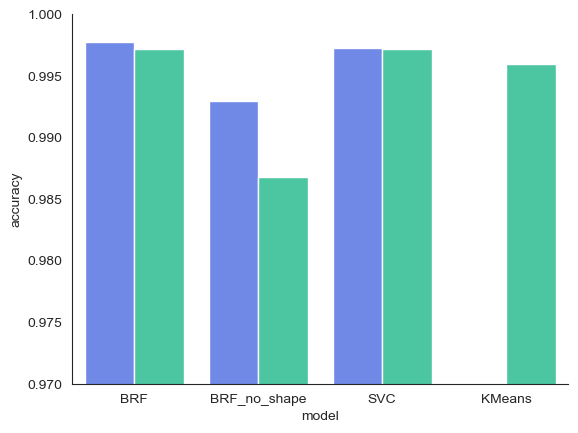

In [69]:
sns.set_style('white')
acc_melt = class_acc.melt(id_vars='model', var_name='score_type', value_name='accuracy')
sns.barplot(acc_melt, x='model', y='accuracy', hue='score_type', palette=['#5c7cfa', '#38d9a9'], legend=False)
plt.ylim(0.97, 1.0)
# plt.xticks(ticks=[])
sns.despine()
plt.tick_params(tick1On=False)

# for i in ax.containers:
#     ax.bar_label(i,)

plt.show()

# 💎 Linear Regression, revisited

Can we improve the performance by removing outliers?

Clear diamonds only this time.

In [43]:
shape_dummies = pd.get_dummies(clear_diamonds['shape'], dtype='int', prefix='shape')
shape_dummies.columns = shape_dummies.columns.str.replace(' ', '_')
clear_diamonds = pd.merge(clear_diamonds.drop(columns=['dominant_color', 'shape']), shape_dummies, left_index=True, right_index=True)

### Outliers in numerical columns

#### Use boxplots to look for outliers

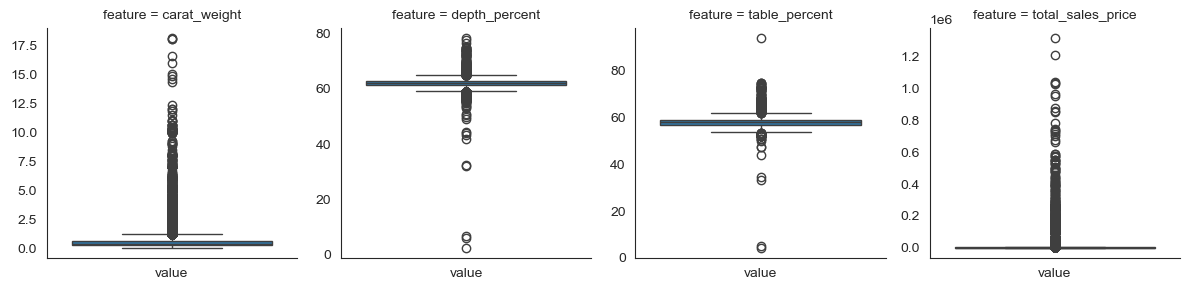

In [44]:
clear_num = clear_diamonds[[c for c in num_vars if c in clear_diamonds.columns]]
clear_num_melted = clear_num.melt(var_name='feature')

sns.set_style('white')
# bp_grid = sns.FacetGrid(clear_num_melted, col='feature', sharey=False)
# bp_grid.map_(sns.boxplot, 'feature', 'value')
# plt.show()

bp_grid = sns.FacetGrid(clear_num_melted, col='feature', sharey=False)
bp_grid.map_dataframe(sns.boxplot)
plt.show()

These are really messy.  Let's look at higher percentiles instead.

#### Use quantiles to define outliers

In [45]:
clear_num.quantile(q=np.arange(0.9, 1.0, 0.01))

,carat_weight,depth_percent,table_percent,total_sales_price
0.90,1.18,63.6,60.0,10889.40
0.91,1.23,63.7,60.0,11953.96
0.92,1.31,63.9,61.0,12833.88
0.93,1.50,64.0,61.0,14406.52
0.94,1.51,64.1,61.0,15710.16
0.95,1.67,64.2,61.0,18469.40
0.96,1.81,64.3,61.0,22410.00
0.97,2.01,64.4,62.0,27468.64
0.98,2.28,64.5,62.0,34651.44
0.99,3.02,64.7,63.0,51186.56


For a given quantile *q* (say 0.90 <= *q* <= 0.99), if I exclude any row that has one or more values at or above its column quantile value, how many/what percent of rows am I retaining?

NB: This code is a single loop that both generates the retention percentage described above and calculates the regression lines & scores for each value of *q*.

In [46]:
retention_pct = {}
scores = []

for q in range(90, 100):
    # qth quantile for each column
    qt = clear_num.quantile(q/100) # Series of quantiles, one for each column
    retained_rows = clear_diamonds[(clear_num < qt).all(axis=1)]
    
    # percent of rows that would be kept
    retention_pct[q] = retained_rows.shape[0] / clear_num.shape[0] * 100

    # model
    X = retained_rows.drop(columns='total_sales_price')
    y = retained_rows['total_sales_price']
    X_train, X_test, y_train, y_svc_test = train_test_split(X, y)
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # log scores
    scores.append((q, lr.score(X_train, y_train), lr.score(X_test, y_svc_test)))

scores_df = pd.DataFrame.from_records(scores, columns=['q', 'training_score', 'testing_score'])

In [47]:
retention_pct

{90: 63.33862340563099,
 91: 64.78810321518839,
 92: 75.40586610239228,
 93: 77.08340680655968,
 94: 78.79856580262152,
 95: 81.0051137365544,
 96: 82.99065420560747,
 97: 89.79133603714806,
 98: 92.16128842649739,
 99: 96.58849115382354}

##### Graph the retention percentages for 0.90 <= *q* <= 0.99 

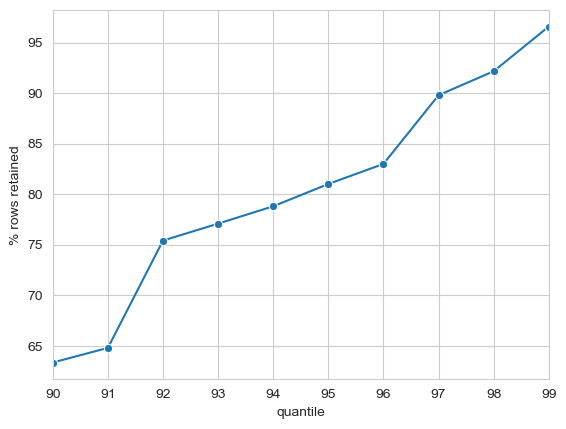

In [48]:
sns.set_style("whitegrid")
retention = pd.Series(retention_pct)
retention_plot = sns.lineplot(retention, marker="o")
plt.xlabel('quantile')
plt.ylabel('% rows retained')
plt.xlim(90, 99)
plt.xticks(range(90, 100, 1))
plt.show()

##### Graph the model scores for 0.90 <= *q* <= 0.99 

In [49]:
scores_df

,q,training_score,testing_score
0,90,0.904843,0.904632
1,91,0.900153,0.896772
2,92,0.892972,0.894707
3,93,0.890181,0.888135
4,94,0.888495,0.886858
5,95,0.889892,0.893631
6,96,0.889574,0.890466
7,97,0.882511,0.884475
8,98,0.876424,0.875695
9,99,0.865372,0.864760


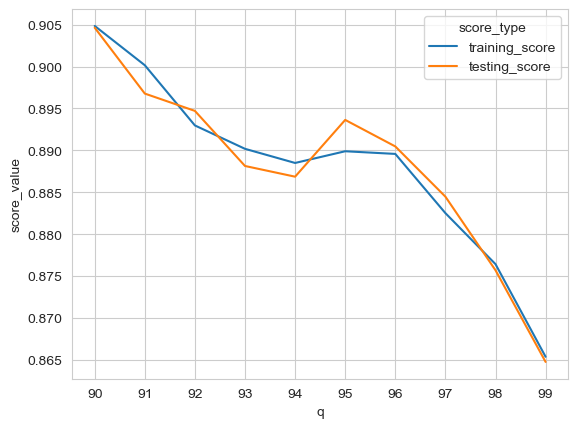

In [75]:
sns.set_style("whitegrid")
scores_melt = scores_df.melt(id_vars='q', var_name='score_type', value_name='score_value')
sns.lineplot(scores_melt, x='q', y='score_value', hue='score_type')
plt.xticks(range(90, 100, 1))
# plt.yticks(np.arange(0.6, 1.0, 0.05)) # Previous score was 0.62
plt.show()